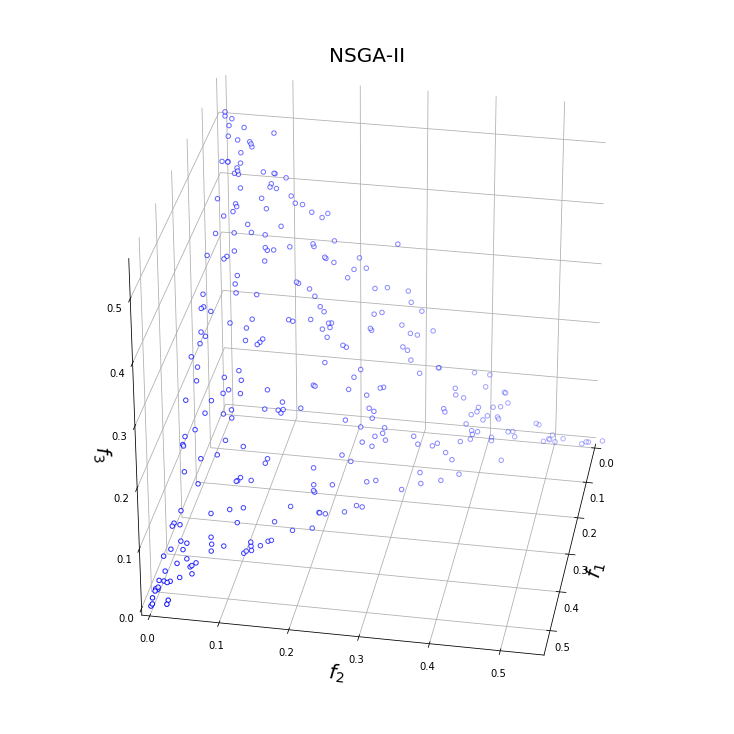

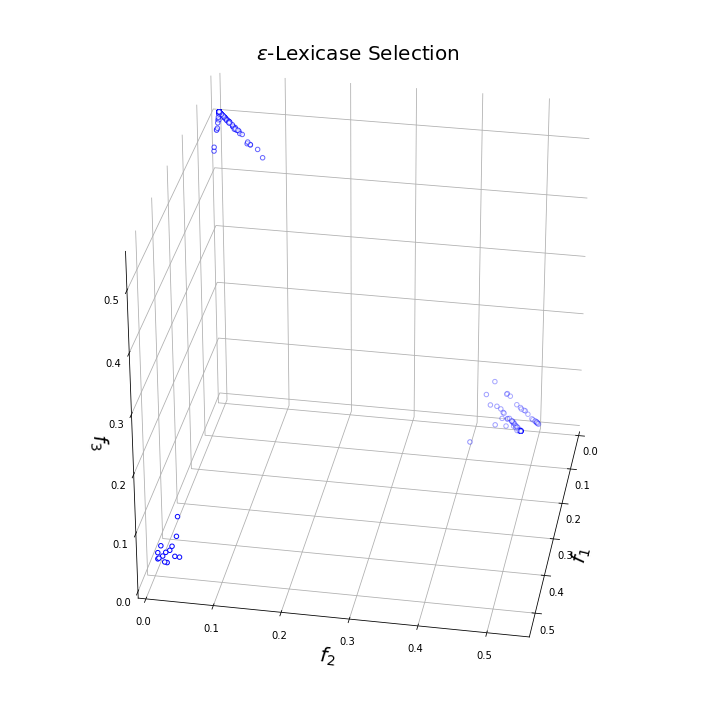

In [9]:
import numpy as np
X = []
g='100'
with open('dtlz1_nsga2.'+g,'r') as f:
	for lines in f:
		if lines !='\n':
			X.append([(float(x)) for x in lines.strip().split(' ')])
Xl = []
with open('dtlz1_lex.'+g,'r') as f:
	for lines in f:
		if lines !='\n':
			Xl.append([(float(x)) for x in lines.strip().split(' ')])
            
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline 
a = 30
b = 10
lim = 0.55
fig = plt.figure(figsize=(10,10),facecolor='white')
ax = fig.add_subplot(111, projection='3d')
X = np.array(X)
ax.scatter(X[:,0],X[:,1],X[:,2],color=None,facecolor='w',edgecolors='b')
ax.set_xlim(0,lim); ax.set_xlabel('$f_1$',size=20); ax.xaxis._axinfo['label']['space_factor'] = 10
ax.set_ylim(0,lim); ax.set_ylabel('$f_2$',size=20)
ax.set_zlim(0,lim); ax.set_zlabel('$f_3$',size=20)
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.view_init(a, b)
ax.set_title('NSGA-II',size=20)
fig.set_facecolor('w')
fig.tight_layout(pad=0.1, w_pad=0.1, h_pad=0.1)
fig.savefig('figs/dtlz1_m3_nsga2.pdf',bbox_inches='tight')

fig2 = plt.figure(figsize=(10,10))
ax2 = fig2.add_subplot(111, projection='3d')
Xl = np.array(Xl)
ax2.scatter(Xl[:,0],Xl[:,1],Xl[:,2],color=None,facecolor='w',edgecolors='b')
ax2.set_xlim(0,lim); ax2.set_xlabel('$f_1$',size=20);
ax2.set_ylim(0,lim); ax2.set_ylabel('$f_2$',size=20)
ax2.set_zlim(0,lim); ax2.set_zlabel('$f_3$',size=20,rotation=90)
ax2.set_title('$\epsilon$-Lexicase Selection',size=20)
ax2.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax2.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax2.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax2.view_init(a,b)
# fig2.tight_layout(pad=0, w_pad=0, h_pad=0)
fig2.tight_layout()

fig2.savefig('figs/dtlz1_m3_lex.pdf',bbox_inches='tight')
plt.show()


In [ ]:
# Selection Probability Analysis

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import pdb
import itertools as it
import scipy.stats as ss
from statsmodels import robust

"""epsilon Lexicase Selection Probability"""
def ep_elite(N,k,ep_k):
    """ return subset of N that is elite on case k"""
    min_fit = min([n.fit[k] for n in N])
    return [n for n in N if n.fit[k] <= min_fit+ep_k]

def ep_lex_prob(N, T, i, ep,dynamic=False,printing=False):
    """computes the probability of an individual being selected.
    N: population with fitness attribute .fit
    T: test cases e.g. [0, 1, 2, 3]
    i: individual whose probability of selection is returned
    dynamic: false: semidynamic lexicase (epsilon doesn't change)
             true: dynamic lexicase (epsilon re-calculated among new elites)
    """
    if len(N)==1:
#         if printing: print("1",end='')
        if printing: print('n_'+str(i.id),end='')
        return 1
    if len(T)==0:
#         if printing: print('1/'+str(len(N)),end='')
        if printing: print('{'+ ','.join(['n_'+str(n.id) for n in N]) + '}',end='')
        return 1/len(N)

    K = ep_elite_cases(i,N,ep,T)
#     if printing: print('K:',K)
    if not K:
        if printing: print('0',end='')
        return 0

    prob = 0

#     if printing: print('1/',len(T),'*(',end='',sep='')

    for q,k_s in enumerate(K):
        if printing: 
#             if q>0: print('+',end='')
            print('\n\t-> t_', k_s+1,'[ep=',ep[k_s],',elite= ' +
                  ','.join(['n_'+str(n.id) for n in ep_elite(N,k_s,ep[k_s])]),'] (',end='')
        T1 = [t for t in T if t!=k_s]
        if dynamic:
            new_ep = get_eps(ep_elite(N,k_s,ep[k_s]))
#             if printing: print('new_ep:',new_ep[k_s],'] (',end='')
#             print('old ep:',ep)
#             print('new ep:', new_ep)
            prob += 1/len(T)*ep_lex_prob(ep_elite(N,k_s,ep[k_s]),T1,i,new_ep,dynamic=True,printing=printing)
        else:   
            prob += 1/len(T)*ep_lex_prob(ep_elite(N,k_s,ep[k_s]),T1,i,ep,printing=printing)

        if printing: print(')')
    return prob

def ep_elite_cases(i,N,ep,T=None):
    """return the cases for which i is elite in N.
    if T provided, calculate eliteness w.r.t. T instead of all the fitness
    values in i.fit.
    """
    min_fit = []
    for t in np.arange(len(i.fit)):
        min_fit.append(min([n.fit[t] for n in N]))
    # pdb.set_trace()
    if T:
        return [x for x,f in enumerate(i.fit) if f <= min_fit[x]+ep[x] and x in T]
    else:
        return [x for x,f in enumerate(i.fit) if f <= min_fit[x]+ep[x]]

def get_eps(N):
    """return epsilon for each case among N"""
    ep = []
    
    for t in np.arange(len(N[0].fit)):
        ep.append(robust.mad(np.array([n.fit[t] for n in N]),c=1))
  
    return [round(e, 4) for e in ep]

class ind():
    def __init__(self,id):
        self.fit = []
        self.id = id
        self.rank = None
        self.mae = None

w: [   10.            12.74274986    16.23776739    20.69138081    26.36650899
    33.59818286    42.81332399    54.55594781    69.51927962    88.58667904
   112.88378917   143.84498883   183.29807108   233.57214691   297.63514416
   379.26901907   483.29302386   615.84821107   784.75997035  1000.        ]
8000
pop size: 8000
objs: 3
sum Psel:  1.0


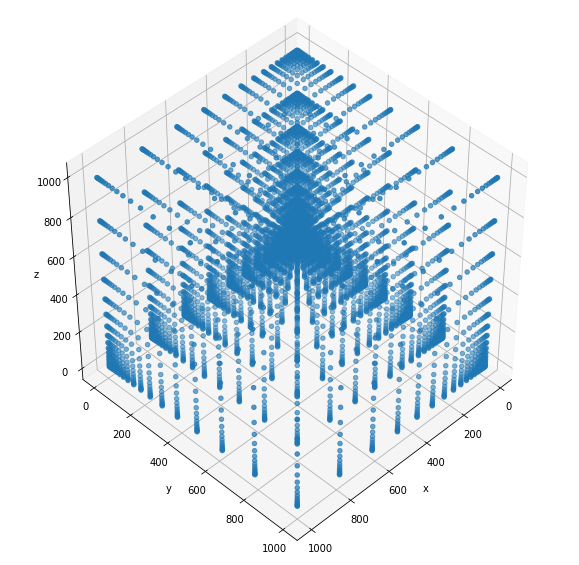

In [3]:

    
# TODO: make a grid of weights and construct the fitnesses that way
w = np.logspace(1.00,3.00,20)
#w = (w - np.min(w))/(np.max(w)-np.min(w))
#w = np.linspace(0,1.0,10)
print('w:',w)
import itertools
W = list(itertools.product(w,w,w))
print(len(W))
#print('W:',W)
pop=[]
for p in np.arange(len(W)):
    pop.append(ind(p+1))
    
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
X = np.array(W)
ax.scatter(X[:,0],X[:,1],X[:,2])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(45,45)
for i,w in enumerate(W):
    #print('w:',w)
    #wt = [w_i-1 for w_i in w]
    pop[i].fit = np.array([0.5 * w_i / np.sum(w) for w_i in w])
    #print('pop[i].fit:',pop[i].fit)
# with open('pareto_fronts/dtlz1_m3.pf','r') as f:
#     for i,line in enumerate(f):
#         pop[i].fit = np.array([float(x) for x in line.strip().split(',')])

print('pop size:',len(pop))
print('objs:',len(pop[0].fit))
Psel_eplex_semi = []
T = [0,1,2]

for p in pop:        
    Psel_eplex_semi.append(ep_lex_prob(pop,T,p,get_eps(pop)))
print('sum Psel: ' ,np.sum(Psel_eplex_semi))
# make matrix of pop fitness
X = []
for p in pop:
    X.append(p.fit)
X = np.array(X)



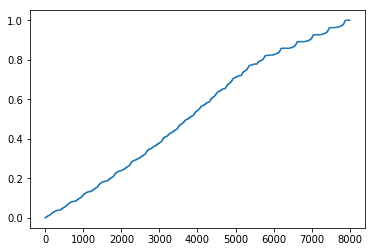

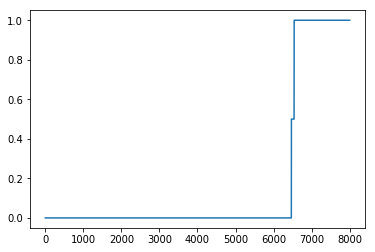

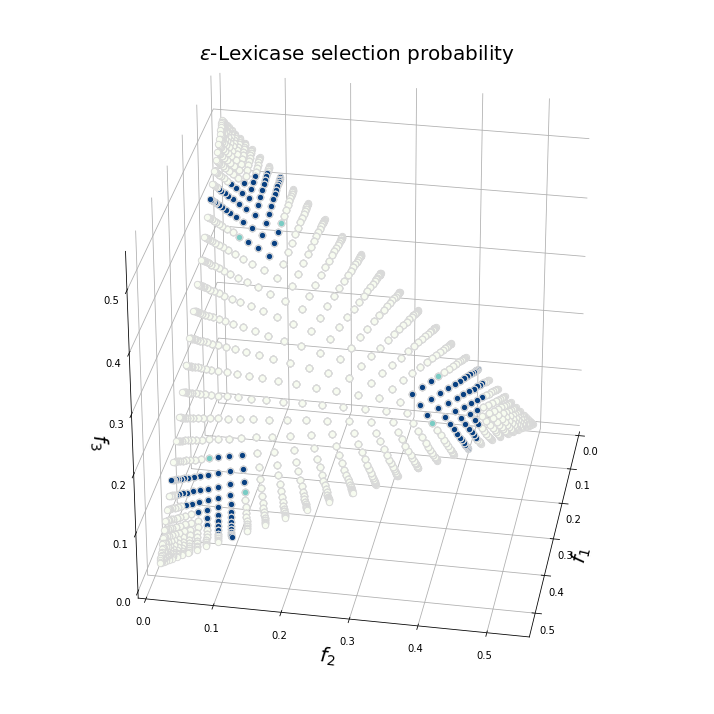

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
%matplotlib inline 
Pnorm = np.array(Psel_eplex_semi)
psum= np.cumsum(Pnorm)
plt.plot(psum)
#Pnorm = np.array([np.exp(-p**2) for p in Pnorm])
Pnorm = Pnorm/np.max(Pnorm)
h = plt.figure()
plt.plot(np.sort(Pnorm))
colors = cm.GnBu(Pnorm)
#print('colors:',colors)
a = 30
b = 10
lim = 0.55
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

plots=[]
for x,c in zip(X,colors):
    scat = ax.scatter(x[0],x[1],x[2],color=c,edgecolor=[0.85,0.85,0.85],s=40)
    plots.append(scat)
ax.set_xlim(0,lim)
ax.set_xlabel('$f_1$',size=20)
ax.set_ylim(0,lim)
ax.set_ylabel('$f_2$',size=20)
ax.set_zlim(0,lim)
ax.set_zlabel('$f_3$',size=20);
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.view_init(a, b)
#fig.colorbar(plots, cmap=colors)
ax.set_title('$\epsilon$-Lexicase selection probability',size=20)
fig.tight_layout()
fig.savefig('figs/dtlz1_m3_ep_lex_probability.pdf',bbox_inches='tight')
plt.show()

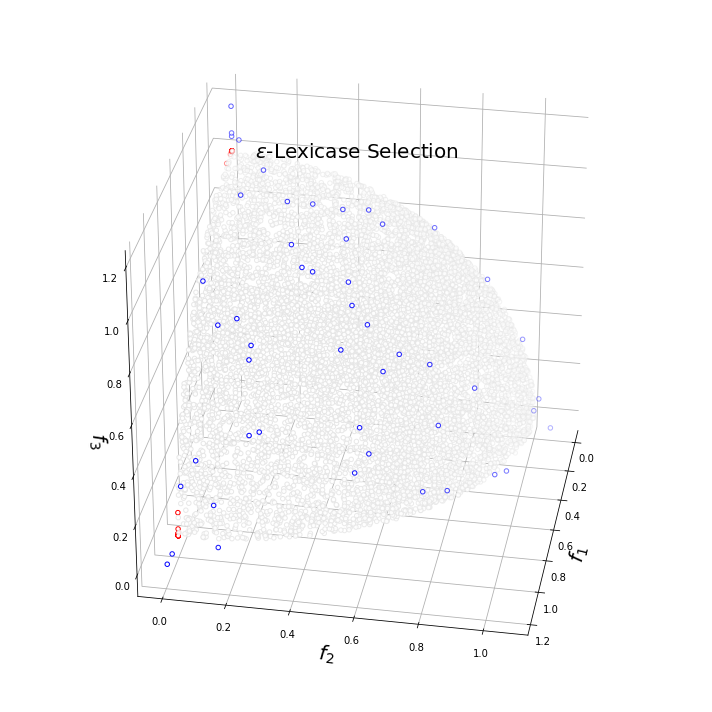

In [23]:
import numpy as np
X = []
g='500'
ddir = '../code/trial_1/runs/'
with open(ddir+'dtlz2_m3_nsga2.'+g,'r') as f:
	for lines in f:
		if lines !='\n':
			X.append([(float(x)) for x in lines.strip().split(' ')])
Xl = []
with open(ddir+'dtlz2_m3_lex.'+g,'r') as f:
	for lines in f:
		if lines !='\n':
			Xl.append([(float(x)) for x in lines.strip().split(' ')])
XP = []
with open('pareto_fronts/dtlz2_m3.pf','r') as f:
	for lines in f:
		if lines !='\n':
			XP.append([(float(x)) for x in lines.strip().split(',')])
            
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline 
a = 30
b = 30
lim = 0.55
fig = plt.figure(figsize=(10,10),facecolor='white')
ax = fig.add_subplot(111, projection='3d')

XP = np.array(XP)
ax.scatter(XP[:,0],XP[:,1],XP[:,2],color=None,facecolor='w',edgecolors=[0.9,0.9,0.9])
# ax2.set_xlim(0,lim); 
ax.set_xlabel('$f_1$',size=20);
# ax2.set_ylim(0,lim); 
ax.set_ylabel('$f_2$',size=20)
# ax2.set_zlim(0,lim); 
ax.set_zlabel('$f_3$',size=20,rotation=90)
ax.set_title('Pareto Front',size=20)
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.view_init(a,b)
# fig2.tight_layout(pad=0, w_pad=0, h_pad=0)
fig.tight_layout()

X = np.array(X)
ax.scatter(X[:,0],X[:,1],X[:,2],color=None,facecolor='w',edgecolors='b')
# ax.set_xlim(0,lim); 
ax.set_xlabel('$f_1$',size=20); ax.xaxis._axinfo['label']['space_factor'] = 10
# ax.set_ylim(0,lim); 
ax.set_ylabel('$f_2$',size=20)
# ax.set_zlim(0,lim); 
ax.set_zlabel('$f_3$',size=20,rotation=90)
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.view_init(a, b)
ax.set_title('NSGA-II',size=16)
fig.set_facecolor('w')
fig.tight_layout(pad=0.1, w_pad=0.1, h_pad=0.1)

# fig = plt.figure(figsize=(10,10))
# ax = fig2.add_subplot(111, projection='3d')
Xl = np.array(Xl)
ax.scatter(Xl[:,0],Xl[:,1],Xl[:,2],'s',color=None,facecolor='w',edgecolors='r')
# ax2.set_xlim(0,lim); 
ax.set_xlabel('$f_1$',size=20);
# ax2.set_ylim(0,lim); 
ax.set_ylabel('$f_2$',size=20)
# ax2.set_zlim(0,lim); 
ax.set_zlabel('$f_3$',size=20,rotation=90)
ax.set_title('DTLZ2',size=20)
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.view_init(a,b)
# fig2.tight_layout(pad=0, w_pad=0, h_pad=0)
fig.tight_layout()




plt.show()